# Fit Instrument transmission using Linear Fit in numpy

The purpose is to fit Bouguer lines to find Instrument transmission


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 22th 2020
- update : September 23th 2020  : cut tail for order 2
- update : october 6th 2020 : Set surface to 1cm2 in pysynphot

# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
from astropy.table import Table

In [4]:
from scipy import interpolate

In [5]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [6]:
# analytic for removing rayleigh
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [7]:
import libatmscattering as atm

In [8]:
import seaborn as sns

In [9]:
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [10]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [11]:
import scipy.special as sp

In [12]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

In [13]:
import libLSSTFiltersKG as lsst

liblsstfilter_path= ../../data/lsst/LSSTFiltersKG


In [14]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

# Pre defined Functions

In [15]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

## Functions to select the CALSPEC

In [16]:
def GetListOfCalspec(file_sedsummary="sed/table_summary_allcalspec_torenorm.fits"):
    """
    GetListOfCalspec()
    
    the file include SED fro which color term has been caculated 
    in /examples_sed/calspec/ViewCalspecColors.ipynb
    
    - input:
      file_sedsummary : filename of SED summary
      
    - output:
      t : astropy table of summary 
    """

    t=Table.read(file_sedsummary)
    return t

In [17]:
def SelectFewSED(t):
    """
    SelectFewSED(t)
    
    input : 
     - t astropy table of SED
     
    output :
    - t_selected : table of presselected SED
     
    """
    
    all_colors=t["VmI"]
    
    
    # list of target colors
    target_VmI=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    NBVmItarget=len(target_VmI)
    
    filesselected_index=np.zeros(NBVmItarget)
    filesselected_VmI=np.zeros(NBVmItarget)
    
    idx=0
    for vmi in target_VmI:
        thevmi,theidx=find_nearest(all_colors,vmi)
        #print(thevmi,theidx)
        filesselected_index[idx]=int(theidx)
        filesselected_VmI[idx]=thevmi
        idx+=1  
        
    t_selected=Table(t[0])
    for idx in filesselected_index[1:]:
        t_selected.add_row(t[int(idx)])
        
    return t_selected
    

In [18]:
def plot_sed(t,ax):
    """
    
    plot_sed(t, ax) : Plot SED from the astropy table t

    input:
        - t : tables of SED
        - ax : matplotlib axis

    """
    
    NBFILES=len(t)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)
    
    idx=0
    
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')

    for filename in t["FILES"]:
    
        # read the calspec file
        fullfilename=os.path.join(path_sed_calspec,filename)
        
        if filename=="flat":
            spec=flatsp
            spec_norm=spec
        else:
            spec=S.FileSpectrum(fullfilename)
        
        spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
        spec_norm.convert('photlam')
        #spec_norm.convert('nm')    
        
        #WLMINSEL=340.
        #WLMAXSEL=1100.


        magV=t["magV"][idx]
        label=t["OBJNAME"][idx]+" ( "+t["SP_TYPE"][idx]+" ) "+" magV = {:.2g}".format(magV) +" v-i ={:.2f}".format(t["VmI"][idx])
        
        
        
        #X= spec_norm.wave[wavelengths_indexes]    
        #Y= spec_norm.flux[wavelengths_indexes]  
        
        X= spec_norm.wave   
        Y= spec_norm.flux 
        
        wavelengths_indexes=np.where(np.logical_and(spec_norm.wave>WLMINSEL*10, spec_norm.wave<WLMAXSEL*10))[0]
        
        
        #if filename!="flat":
        cm=ax.plot(X[wavelengths_indexes], Y[wavelengths_indexes],color=all_colors[idx],label=label)
        
        idx+=1
    
    #ax.set_xlim(3500.,11000.)
    #ax.set_ylim(0.,3.)
    ax.legend()
    ax.grid()


    xlabel=' $\\lambda$ (Angstrom)'
    ylabel=' Flux (photlam) normalised to Mag-10'
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_title("Preselected CALSPEC relative SED")
    
    return cm

    
    

## Functions to build spectrum 

In [19]:
def GetSpectra(sed,wl_atm,atm_transmission, order2=False,cut=False):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
   
    
    # quantum efficiency
    wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")
    bp_qe= S.ArrayBandpass(wl_ccd*10.,ccdqe, name='QE')
    
    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    # Hologram transmission (analytic)
    X0=10000 # in antstrom
    X=wl0
    X2=np.sort(np.unique(np.concatenate((wl0/2,wl0)))) 
    Eff_holo=sp.jv(1, X0/X)**2
    Eff_holo2=sp.jv(2, X0/X2)**2
    
    bp_holo_order1= S.ArrayBandpass(X,Eff_holo, name='Holo')
    bp_holo_order2= S.ArrayBandpass(X2,Eff_holo2, name='Holo2')
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    for i_atm in np.arange(Natm):
        bp_all_order1=bp_qe*all_bp_atm[i_atm]* bp_holo_order1
        bp_all_order2=bp_qe*all_bp_atm[i_atm]* bp_holo_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
      
    if cut:
         wlcut_indexes = np.where(wl_atm_ang<7600)[0]
         spectra2[:,wlcut_indexes]=0
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

In [20]:
def GetSpectraNoAtm(sed,wl_atm,atm_transmission, order2=False,cut=False):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
    
    
    # quantum efficiency
    wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")
    bp_qe= S.ArrayBandpass(wl_ccd*10.,ccdqe, name='QE')
    
    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    # Hologram transmission (analytic)
    X0=10000 # in antstrom
    X=wl0
    X2=np.sort(np.unique(np.concatenate((wl0/2,wl0)))) 
    Eff_holo=sp.jv(1, X0/X)**2
    Eff_holo2=sp.jv(2, X0/X2)**2
    
    bp_holo_order1= S.ArrayBandpass(X,Eff_holo, name='Holo')
    bp_holo_order2= S.ArrayBandpass(X2,Eff_holo2, name='Holo2')
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    # remoove atmosphere and qe
    # keep  hologram
    for i_atm in np.arange(Natm):
        #bp_all_order1=bp_qe*all_bp_atm[i_atm]* bp_holo_order1
        #bp_all_order2=bp_qe*all_bp_atm[i_atm]* bp_holo_order2
        
        bp_all_order1 = bp_holo_order1
        bp_all_order2 = bp_holo_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
        
    if cut:
        wlcut_indexes = np.where(wl_atm_ang<7600)[0]
        spectra2[:,wlcut_indexes]=0
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

## Functions for Plotting

In [21]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot estimated parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        r'$\mu$={:3.2g}'.format(mu),
        r'$median$={:3.2g}'.format(median),
        r'$\sigma$={:3.2g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [22]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3g}'.format(mu),
    '$median$={:.3g}'.format(median),
    '$\sigma$={:.3g}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=(-3,-3), 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [23]:
def plotcorrelation(ax,all_Y):
    """
    """
    
    df=pd.DataFrame(data=all_Y,columns=['VAOD', 'PWV', 'OZONE',"CLD-OD"])
    Var_Corr = df.corr()
    mask_ut=np.triu(np.ones(Var_Corr.shape)).astype(np.bool)
    mask_lt=np.logical_not(np.tril(np.ones(Var_Corr.shape)).astype(np.bool))
    
    sns.heatmap(Var_Corr,mask=mask_lt,vmin=0, vmax=1 ,xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,ax=ax,cmap="jet")

In [24]:
#-----------------------------------------------------------------------------------------------------------------------
def plot_ml_result(Yin,Yout,mode,title):
    """
    plot_ml_result(Yin,Yout,mode,title)

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param(0, ax, Yin, Yout, mode)

    ax = fig.add_subplot(222)
    plot_param(1, ax,Yin, Yout, mode)

    ax = fig.add_subplot(223)
    plot_param(2, ax, Yin, Yout, mode)

    ax = fig.add_subplot(224)
    plot_param(3, ax, Yin, Yout, mode)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#--------------------------------------------

In [25]:
def histo_ml_result(Yin, Yout, title):
    """

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param_histo(0, ax, Yin, Yout)

    ax = fig.add_subplot(222)
    plot_param_histo(1, ax, Yin, Yout)

    ax = fig.add_subplot(223)
    plot_param_histo(2, ax, Yin, Yout)

    ax = fig.add_subplot(224)
    plot_param_histo(3, ax, Yin, Yout)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#---------------------------------------------

In [26]:
def plot_regularisation_coeff(alphas,alpha0,allcoefs,title):
    """

    plot_regularisation_coeff(alpha,all_coeff,title) : plot coefficient vrt regularisation parameter

    :param alphas: regularisation parameters
    : param alpha0 : vertical line
    :param allcoefs: coefficient
    :param title: title
    :return:
    """

    N = allcoefs.shape[2] # number of coefficients
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(221)
    for idx in np.arange(allcoefs.shape[2]):
        ax1.plot(alphas, allcoefs[:, 0, idx], color=all_colors[idx])
    ax1.set_xscale('log')
    ax1.axvline(x=alpha0, color='red')
    ax1.set_ylabel('weights - vaod')
    ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
    ax1.grid(True)
    ax1.set_title(title)

    ax2 = fig.add_subplot(222, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax2.plot(alphas, allcoefs[:, 1, idx], color=all_colors[idx])
    ax2.axvline(x=alpha0, color='red')
    ax2.set_xscale('log')
    ax2.set_ylabel('weights - H2O')
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
    ax2.grid(True)

    ax3 = fig.add_subplot(223, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax3.plot(alphas, allcoefs[:, 2, idx], color=all_colors[idx])
    ax3.axvline(x=alpha0, color='red')
    ax3.set_ylabel('weights - O3')
    ax3.set_xscale('log')
    ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
    ax3.grid(True)

    ax4 = fig.add_subplot(224, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax4.plot(alphas, allcoefs[:, 3, idx], color=all_colors[idx])
    ax4.axvline(x=alpha0, color='red')
    ax4.set_ylabel('weights - CLD')
    ax4.set_xscale('log')
    # ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
    ax4.set_xlim(ax4.get_xlim())  # reverse axis
    ax4.grid(True)

    plt.xlabel('alpha')
    plt.axis('tight')

    plt.tight_layout()
    plt.show()



# GetAtmTransparency

In [27]:
def GetAtmTransparency(inputdir,filelist):
    """
    GetAtmTransparency(inputdir, filelist): retrieve atmospheric transparency from simulation

    input arguments:
     - inputdir : input directory
     - filelist : list of file to read
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        

# Initialisation

In [28]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))

LA time: 09:46:07
NY time: 12:46:07
London time: 17:46:07
Paris time: 18:46:07


# Configuration

In [29]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')


In [30]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-02-19 18:46:07,415 MacBook-Pro-de-admin.local __main__[27680] INFO LA time:09:46:07
2022-02-19 18:46:07,417 MacBook-Pro-de-admin.local __main__[27680] INFO NY time:12:46:07
2022-02-19 18:46:07,418 MacBook-Pro-de-admin.local __main__[27680] INFO London time:17:46:07
2022-02-19 18:46:07,419 MacBook-Pro-de-admin.local __main__[27680] INFO Paris time:18:46:07
2022-02-19 18:46:07,420 MacBook-Pro-de-admin.local __main__[27680] INFO ************************ START *********************


In [31]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [32]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-02-19 18:46:07,433 MacBook-Pro-de-admin.local __main__[27680] INFO Configuration file : config/default.ini


In [33]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2022-02-19 18:46:07,440 MacBook-Pro-de-admin.local __main__[27680] INFO 1) Configuration


In [34]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [35]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    
    NPOINTSVIEW = int(config['GENERAL']['NPOINTSVIEW'])
    NPOINTSSAVE = int(config['GENERAL']['NPOINTSSAVE'])
    
    
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)


if 'MLFIT'in config_section:
    input_file = config['MLFIT']['inputfile']
    input_dir = config['MLFIT']['inputdir']

    packetsize = int(config['MLFIT']['packetsize'])
    maxnbpacket = int(config['MLFIT']['maxnbpacket'])

    input_file_split=input_file.split(".")    
    basefilename=input_file_split[0]
    extendfilename=input_file_split[1]
else:
    msg="Configuration file : Missing section MLFIT in config file {config_filename} !"
    logger.error(msg)
    

# Atmospheric transparency file and selection

In [36]:
all_files = os.listdir(input_dir)
sorted_files=sorted(all_files)

In [37]:
# search string
search_str="^"+f"{basefilename}.*fits$"

In [38]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

### Keep a limited number of input files

In [39]:
if maxnbpacket>0:
    selected_files=selected_files[:maxnbpacket]

In [40]:
NFiles=len(selected_files)

# Read simulated atmospheric transparency

In [41]:
wl,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(input_dir,selected_files)

In [42]:
logger.info(header)

2022-02-19 18:46:08,285 MacBook-Pro-de-admin.local __main__[27680] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  957                                                  NAXIS2  =                  101                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [43]:
num=datain[0:,idx_num]
airmass=datain[0:,idx_am]
vaod=datain[0:,idx_vaod] # vertical aerosol depth
pwv=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone=datain[0:,idx_o3]     # ozone
cld=datain[0:,idx_cld]   # clouds (not us

In [44]:
transm=datain[:,idx_res:]

/Users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
2022-02-19 18:46:09,373 MacBook-Pro-de-admin.local matplotlib.legend[27680] WARNING No handles with labels found to put in legend.


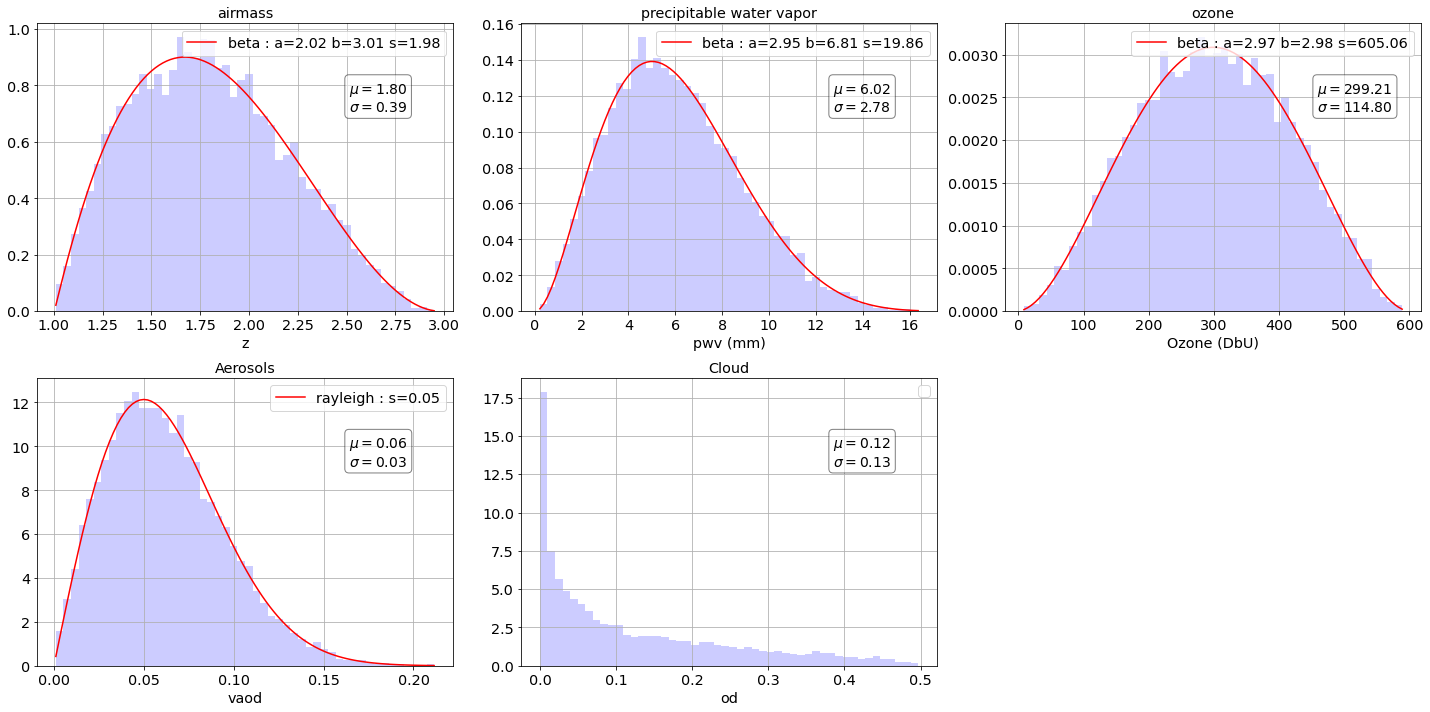

In [45]:
def GetDistribFromName(name):
    """
    
    GetDistribFromName(name): Get distribution from name in config file
    
    input arg:
    
    - name : string name of the distribution
    
    """
    
    rayleigh,beta,gamma,uniform
    
    if name=="rayleigh":
        return rayleigh
    elif name=="beta":
        return beta
    elif name=="gamma":
        return gamma
    else:
        return uniform
    


if FLAG_PLOT:
    fig=plt.figure(figsize=(20,10))
    ax1=fig.add_subplot(231)
    ax2=fig.add_subplot(232)
    ax3=fig.add_subplot(233)
    ax4=fig.add_subplot(234)
    ax5=fig.add_subplot(235)
    #ax6=fig.add_subplot(326)

    # -----------------  airmass
    mu=np.average(airmass)
    sigma=np.std(airmass)
    ax1.hist(airmass,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))


    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax1.text(0.75, 0.8, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    
    
    if 'AIRMASS' in config_section:
        distrib_name= config['AIRMASS']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(airmass)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(airmass.min(),airmass.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        ax1.plot(x,pdf,"r-",label=label)
        ax1.legend()
        ax1.grid()
    
    #----------------pwv--------------------
    
    mu=np.average(pwv)
    sigma=np.std(pwv)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax2.hist(pwv,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    
    ax2.text(0.75, 0.8, textstr, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    if 'PWV' in config_section:
        distrib_name= config['PWV']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(pwv)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(pwv.min(),pwv.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax2.plot(x,pdf,"r-",label=label)
        ax2.legend()
        ax2.grid()
    
        
    #-------------- Ozone
    
    mu=np.average(ozone)
    sigma=np.std(ozone)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax3.hist(ozone,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    
    ax3.text(0.75, 0.8, textstr, transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'OZONE' in config_section:
        distrib_name= config['OZONE']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(ozone)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(ozone.min(),ozone.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax3.plot(x,pdf,"r-",label=label)
        ax3.legend()
        ax3.grid()
    
    
    #-------------------- VAOD
    
    mu=np.average(vaod)
    sigma=np.std(vaod)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    ax4.hist(vaod,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    
    ax4.text(0.75, 0.8, textstr, transform=ax4.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'AEROSOL' in config_section:
        distrib_name= config['AEROSOL']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(vaod)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(vaod.min(),vaod.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        ax4.plot(x,pdf,"r-",label=label)
        ax4.legend()
        ax4.grid()
    
    #-------------- clouds
    
    mu=np.average(cld)
    sigma=np.std(cld)
    textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    
    ax5.hist(cld,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")
    
    ax5.text(0.75, 0.8, textstr, transform=ax5.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    
    if 'CLOUD' in config_section:
        distrib_name= config['CLOUD']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(cld)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(cld.min(),cld.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        #ax5.plot(x,pdf,"r-",label=label)
        ax5.legend()
        ax5.grid()
        
        
    plt.tight_layout()

### Select wavelength range

Truncate wavelength

In [46]:
WLMINSEL=340.
WLMAXSEL=1100.

In [47]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [48]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [49]:
wl=wl[indexes_selected]
transm_tot=transm[:,indexes_selected]

### Remove rayleigh component

In [50]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [51]:
transm=transm_tot/att_rayleigh

### Not removing the rayleigh

In [52]:
transm=transm_tot

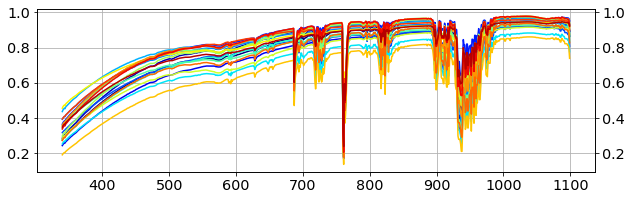

In [53]:
if FLAG_PLOT:
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,transm[idx,:],c=all_colors[idx])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

In [54]:
NWL=wl.shape[0]

In [55]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data : X and Y

In [56]:
#cld=3*cld

In [57]:
airmassarr=airmass[:,np.newaxis]
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=ozone[:,np.newaxis]
cldarr=cld[:,np.newaxis]

## Check atmosphere

In [58]:
def GetBouguerLinesAtm(Npoints,FLAG_PLOT=True):
    """
    """
    wl_sel=np.linspace(350,1000,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel ]
    NIWSEL=len(iwl_sel)
    Mags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        if FLAG_CLOUD:
            the_y=-2.5*np.log10(transm[:,iwl]*np.exp(-cld*airmass))
        else:
            the_y=-2.5*np.log10(transm[:,iwl])

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs airmass")
        plt.show()
     
    return wl_sel,Mags
     

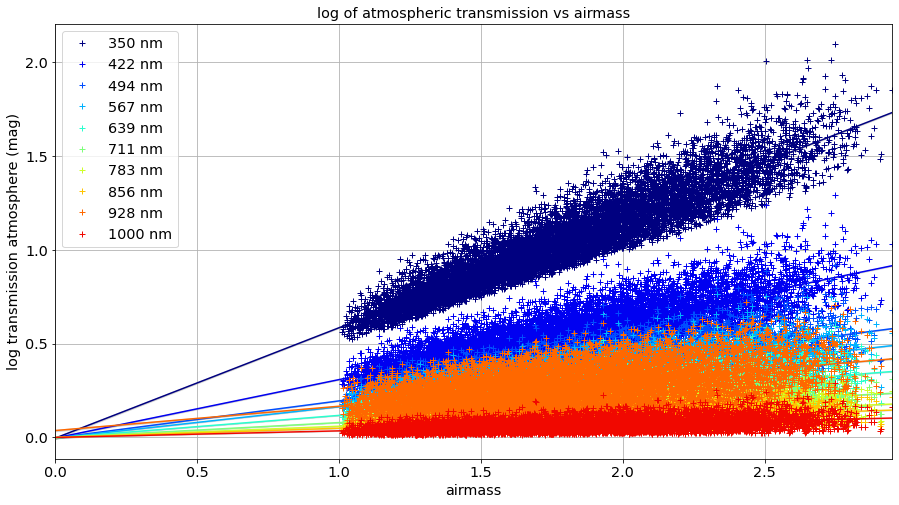

(array([ 350.        ,  422.22222222,  494.44444444,  566.66666667,
         638.88888889,  711.11111111,  783.33333333,  855.55555556,
         927.77777778, 1000.        ]),
 array([-0.00554239, -0.00470151, -0.0042256 , -0.00495751, -0.00378878,
        -0.00236682, -0.00208874, -0.0016911 ,  0.03540577, -0.00123345]))

In [59]:
FLAG_CLOUD=False
NPOINTSVIEW
GetBouguerLinesAtm(NPOINTSVIEW,FLAG_PLOT=True)

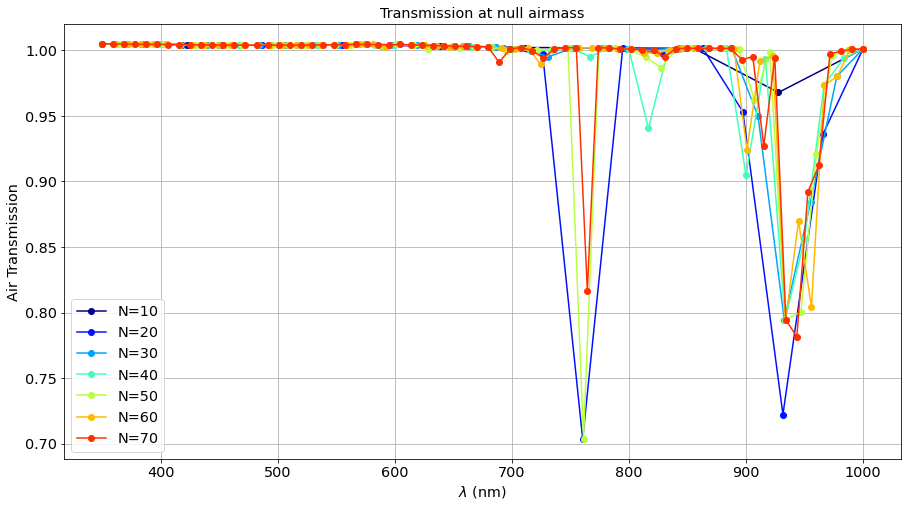

In [60]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,8))
    ax=fig.add_subplot(111)
    
    
    NPOINTS=np.arange(NPOINTSVIEW,80,10)
    NNPOINTS=len(NPOINTS)
    
    N=NNPOINTS
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(NNPOINTS):
        npoints=NPOINTS[idx]
        label=f"N={npoints}"
        w,m=GetBouguerLinesAtm(npoints,False)
        

        ax.plot(w,np.power(10,-m/2.5),'o-',color=all_colors[idx],label=label)

   
    ax.legend()
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("Air Transmission")
    ax.set_title("Transmission at null airmass")

## Clouds

## clouds in input data

In [61]:
transm_cloud=np.exp(-cld*airmass)
transm_cloud_arr=np.exp(-cldarr*airmassarr)

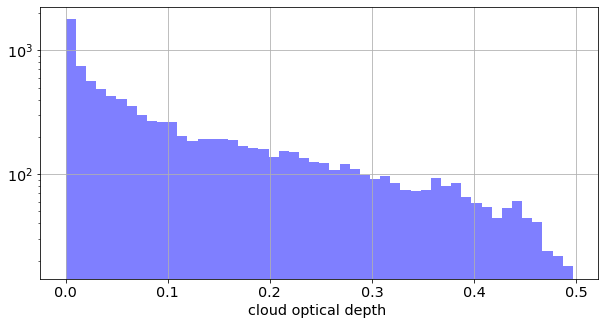

In [62]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,5))

    ax = fig.add_subplot(111)
    ax.hist(cld,bins=50,facecolor="b",label="in data",alpha=0.5)
    ax.set_yscale('log')
    ax.set_xlabel("cloud optical depth ")
    ax.grid()


### concatenate VAOD,PWV, Ozone

In [63]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)
Ylabel=["vaod","pwv","ozone","cld"]

### Use magnitudes for X

In [64]:
t=GetListOfCalspec()
t_sel=SelectFewSED(t)

In [65]:
t_sel

<Table length=8>
 OBJNAME     RA     DEC   SP_TYPE SP_QUAL ...  calcR   calcI    factor     VmI  
 bytes10  float64 float64 bytes12  bytes1 ... float64 float64  float64   float64
--------- ------- ------- ------- ------- ... ------- ------- ---------- -------
  NGC7293 337.411 -20.837   DAO.5       C ...  13.734  14.234      26.01  -0.697
   G93-48 328.106   2.389   DA2.8       C ...  12.836  13.234      12.34  -0.506
      HZ4  58.842   9.788   DA3.4       C ...  14.569  14.723     61.551  -0.250
ALPHA_LYR 279.235  38.784    A0Va       C ...   0.000  -0.004 0.00010079   0.013
 HD163466 268.106  60.396      A2       E ...   6.694   6.589   0.054409   0.251
 HD074000 130.212 -16.345      F2       D ...   9.269   8.987    0.72107   0.658
 HD106252 183.373  10.042      G0       E ...   6.957   6.653   0.091453   0.750
     FLAT   0.000   0.000    flat       0 ...   9.501   9.001          1   0.999

### Show examples of SED to use

2022-02-19 18:46:15,200 MacBook-Pro-de-admin.local astropy[27680] WARNING VerifyWarning: Invalid keyword for column 1: Column disp option (TDISPn) failed verification: Format 26A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2022-02-19 18:46:15,210 MacBook-Pro-de-admin.local astropy[27680] WARNING VerifyWarning: Invalid keyword for column 2: Column disp option (TDISPn) failed verification: Format 18A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2022-02-19 18:46:15,219 MacBook-Pro-de-admin.local astropy[27680] WARNING VerifyWarning: Invalid keyword for column 3: Column disp option (TDISPn) failed verification: Format 56A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2022-02-19 18:46:15,228 MacBook-Pro-de-admin.local astropy[27680] WARNING VerifyWarning: Invalid keyword for column 4: Column disp option (

Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.


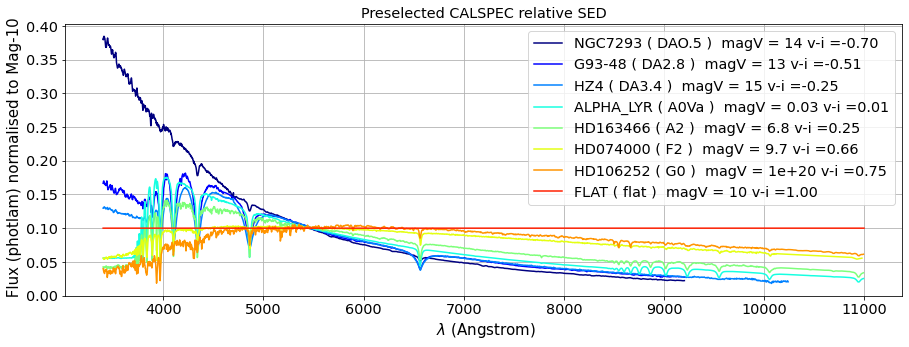

In [66]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(111)
    plot_sed(t_sel,ax)
    plt.show()

# Get the Spectra

### define the filenames

In [67]:
idx_sed_sel=3
sed_filename=t_sel[idx_sed_sel]["FILES"]
sed_objname=t_sel[idx_sed_sel]["OBJNAME"]
sed_fullfilename=os.path.join(path_sed_calspec,sed_filename)
############
order2=False
cut=True
############
if order2 and not cut:
    specarrayfile="spec_"+sed_objname+"_ord12_v1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2_v1.npy"
    
    specarrayfile3="spec_noatmnoqe_"+sed_objname+"_ord12_v1.npy"
    specarrayfile4="spec2_noatmnoqe_"+sed_objname+"_ord2_v1.npy"
    
    
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
    
    title_spec3="spectra order 1 and 2 no atm no qe"
    title_spec4="spectra order 2 no atm no qe"
elif order2 and cut:
    specarrayfile="speccut_"+sed_objname+"_ord12_v1.npy"
    specarrayfile2="spec2cut_"+sed_objname+"_ord2_v1.npy"
    
    specarrayfile3="speccut_noatmnoqe_"+sed_objname+"_ord12_v1.npy"
    specarrayfile4="spec2cut_noatmnoqe_"+sed_objname+"_ord2_v1.npy"
    
    
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
    
    title_spec3="spectra order 1 and 2 no atm no qe"
    title_spec4="spectra order 2 no atm no qe"    
    
    
else:
    specarrayfile="spec_"+sed_objname+"_ord1_v1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2_v1.npy"
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"
    
    specarrayfile3="spec_noatmnoqe_"+sed_objname+"_ord1_v1.npy"
    specarrayfile4="spec2_noatmnoqe_"+sed_objname+"_ord2_v1.npy"
    
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"
    
    title_spec3="spectra order 1 no atm no qe"
    title_spec4="spectra order 2 no atm no qe"
    
    
    

In [68]:
specarrayfile

'spec_ALPHA_LYR_ord1_v1.npy'

In [69]:
specarrayfile2

'spec2_ALPHA_LYR_ord2_v1.npy'

In [70]:
if sed_filename=="flat":
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')
    spec=flatsp
else:
    spec=S.FileSpectrum(sed_fullfilename)
        
spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
spec_norm.convert('photlam')

In [71]:
if not os.path.isfile(specarrayfile) or not os.path.isfile(specarrayfile2) :
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2,cut=cut)
    np.save(specarrayfile,spectra)
    np.save(specarrayfile2,spectra2)   
else:
    spectra=np.load(specarrayfile)
    spectra2=np.load(specarrayfile2)

/Users/dagoret/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
2022-02-19 18:46:16,284 MacBook-Pro-de-admin.local numexpr.utils[27680] INFO NumExpr defaulting to 8 threads.


(((QE * atm0) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm0) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be us

(((QE * atm32) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm32) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm33) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm33) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm34) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm34) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm35) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm35) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm64) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm64) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm65) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm65) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm66) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm66) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm67) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm67) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm96) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm96) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm97) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm97) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm98) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm98) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm99) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm99) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm127) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm128) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm128) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm129) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm129) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm130) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm130) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm131) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm159) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm159) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm160) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm160) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm161) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm161) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm162) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm162) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm190) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm191) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm191) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm192) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm192) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm193) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm193) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm194) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm222) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm222) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm223) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm223) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm224) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm224) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm225) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm225) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm253) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm254) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm254) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm255) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm255) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm256) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm256) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm285) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm285) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm286) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm286) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm287) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm287) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm288) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm288) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm316) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm317) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm317) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm319) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm348) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm348) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm350) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm350) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm351) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm351) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm379) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm380) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm380) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm381) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm381) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm382) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm382) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm383) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm411) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm411) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm412) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm412) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm413) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm413) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm414) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm414) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm442) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm443) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm443) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm444) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm444) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm445) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm445) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm446) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm474) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm474) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm475) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm475) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm476) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm476) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm477) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm477) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm505) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm506) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm506) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm507) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm507) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm508) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm508) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm509) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm537) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm537) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm538) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm538) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm539) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm539) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm540) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm540) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm568) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm569) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm569) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm570) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm570) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm571) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm571) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm572) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm600) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm600) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm601) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm601) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm602) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm602) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm603) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm631) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm632) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm632) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm633) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm633) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm634) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm634) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm635) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm663) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm663) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm664) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm664) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm665) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm665) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm666) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm666) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm694) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm695) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm695) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm696) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm696) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm697) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm697) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm698) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm726) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm726) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm727) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm727) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm728) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm728) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm729) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm729) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm757) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm758) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm758) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm759) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm759) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm760) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm760) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm761) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm789) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm789) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm791) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm791) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm792) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm792) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm820) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm821) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm821) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm822) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm822) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm823) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm823) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm824) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm852) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm852) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm853) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm853) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm854) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm854) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm883) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm884) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm884) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm885) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm885) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm886) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm886) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm887) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm915) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm915) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm916) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm916) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm917) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm917) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm918) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm918) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm946) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm947) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm947) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm948) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm948) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm949) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm949) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm950) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm978) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm978) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm979) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm979) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm980) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm980) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm981) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm981) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm1009) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1010) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1010) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1011) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1013) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1041) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1041) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1042) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1042) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1043) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1043) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1044) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1044) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1072) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1073) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1073) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1074) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1074) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1075) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1075) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1076) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1104) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1104) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1105) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1105) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1106) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1106) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1107) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1107) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1135) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1136) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1136) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1137) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1137) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1138) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1138) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1139) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1167) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1167) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1168) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1168) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1169) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1169) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1170) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1170) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1198) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1199) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1199) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1200) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1200) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1201) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1201) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1202) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1230) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1230) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1231) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1231) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1232) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1232) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1233) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1233) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1261) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1262) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1262) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1263) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1263) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1264) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1264) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1265) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1293) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1293) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1294) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1294) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1295) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1295) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1296) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1296) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1324) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1325) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1325) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1326) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1326) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1327) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1327) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1328) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1356) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1356) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1357) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1357) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1358) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1358) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1359) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1359) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1387) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1388) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1388) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1389) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1389) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1390) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1391) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1419) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1419) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1420) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1420) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1421) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1421) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1422) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1422) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1450) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1451) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1451) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1452) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1452) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1453) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1453) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1454) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1482) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1482) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1483) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1483) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1484) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1484) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1485) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1485) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1513) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1514) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1514) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1515) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1515) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1516) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1516) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1517) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1545) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1545) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1546) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1546) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1547) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1547) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1548) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1548) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1576) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1577) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1577) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1578) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1578) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1579) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1579) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1580) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1608) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1608) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1609) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1609) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1610) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1610) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1611) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1611) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1639) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1640) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1640) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1641) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1641) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1642) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1642) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1643) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1671) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1671) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1672) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1672) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1673) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1673) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1674) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1674) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1702) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1703) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1703) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1704) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1704) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1705) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1705) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1706) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1734) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1734) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1735) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1735) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1736) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1736) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1737) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1737) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1765) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1766) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1769) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1797) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1797) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1798) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1798) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1799) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1799) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1800) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1800) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1828) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1829) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1829) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1830) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1830) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1831) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1831) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1832) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1860) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1860) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1861) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1861) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1862) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1862) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1863) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1863) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1891) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1892) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1892) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1893) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1893) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1894) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1894) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1895) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1923) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1923) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1924) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1924) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1925) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1925) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1926) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1926) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1954) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1955) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1955) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1956) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1956) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1957) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1957) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1958) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1986) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1986) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1987) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1987) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1988) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1988) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1989) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1989) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2017) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2018) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2018) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2019) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2019) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2020) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2020) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2021) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2049) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2049) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2050) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2050) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2051) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2051) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2052) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2052) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2080) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2081) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2081) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2082) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2082) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2083) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2083) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2084) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2112) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2112) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2113) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2113) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2114) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2114) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2115) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2115) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2143) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2144) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2144) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2145) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2145) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2146) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2146) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2147) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2175) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2175) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2176) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2176) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2177) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2177) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2178) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2178) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2206) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2207) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2207) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2208) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2208) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2209) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2209) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2210) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2238) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2238) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2239) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2239) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2240) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2240) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2241) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2241) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2269) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2270) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2270) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2271) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2271) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2272) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2272) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2273) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2301) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2302) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2302) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2303) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2303) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2304) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2304) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2332) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2333) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2333) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2334) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2334) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2335) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2335) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2336) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2364) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2364) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2365) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2365) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2366) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2366) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2367) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2367) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2395) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2396) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2396) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2397) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2397) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2398) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2398) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2399) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2427) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2427) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2428) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2428) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2429) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2429) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2430) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2430) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2458) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2459) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2459) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2460) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2460) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2461) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2461) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2462) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2490) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2490) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2491) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2491) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2492) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2492) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2493) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2493) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2521) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2522) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2522) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2523) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2523) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2524) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2524) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2525) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2553) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2553) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2554) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2554) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2555) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2555) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2556) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2556) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2584) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2585) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2585) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2586) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2586) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2587) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2587) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2588) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2616) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2616) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2617) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2617) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2618) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2618) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2619) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2619) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2647) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2648) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2648) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2649) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2649) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2650) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2650) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2651) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2679) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2679) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2680) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2680) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2681) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2681) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2682) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2682) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2710) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2711) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2711) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2712) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2712) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2713) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2713) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2714) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2742) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2742) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2743) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2743) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2744) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2744) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2745) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2745) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2773) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2774) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2774) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2775) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2775) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2776) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2776) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2777) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2805) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2805) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2806) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2806) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2807) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2807) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2808) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2808) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2836) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2837) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2837) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2838) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2838) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2839) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2839) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2840) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2868) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2868) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2869) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2869) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2870) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2870) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2871) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2871) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2899) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2900) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2900) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2901) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2901) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2902) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2902) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2903) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2931) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2931) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2932) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2932) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2933) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2933) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2934) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2934) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2962) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2963) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2963) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2964) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2964) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2965) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2965) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2966) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2994) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2994) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2995) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2995) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2996) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2996) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2997) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2997) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3025) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3026) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3026) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3027) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3027) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3028) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3028) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3029) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3057) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3057) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3058) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3059) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3059) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3060) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3060) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3088) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3089) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3089) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3090) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3090) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3091) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3091) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3092) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3120) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3120) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3121) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3121) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3122) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3122) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3123) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3123) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3151) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3152) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3152) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3153) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3153) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3154) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3154) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3155) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3183) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3183) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3184) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3184) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3185) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3185) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3186) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3186) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3214) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3215) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3215) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3216) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3216) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3217) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3217) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3218) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3246) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3246) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3247) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3247) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3248) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3248) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3249) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3249) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3277) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3278) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3278) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3279) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3279) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3280) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3280) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3281) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3309) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3309) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3310) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3310) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3311) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3311) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3312) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3312) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3340) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3341) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3341) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3342) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3342) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3343) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3343) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3344) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3372) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3372) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3373) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3373) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3374) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3374) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3375) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3375) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3403) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3404) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3404) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3405) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3405) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3406) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3406) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3407) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3435) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3435) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3436) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3436) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3437) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3437) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3438) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3438) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3466) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3467) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3467) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3468) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3468) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3469) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3469) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3470) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3498) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3498) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3499) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3499) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3500) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3500) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3501) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3501) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3529) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3530) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3530) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3531) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3531) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3532) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3532) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3533) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3561) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3561) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3562) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3562) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3563) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3563) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3564) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3564) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3592) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3593) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3593) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3594) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3594) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3595) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3595) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3596) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3624) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3624) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3625) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3625) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3626) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3626) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3627) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3627) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3655) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3656) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3656) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3657) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3657) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3658) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3658) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3659) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3687) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3687) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3688) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3688) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3689) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3689) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3690) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3690) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3718) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3719) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3719) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3720) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3720) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3721) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3721) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3722) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3750) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3750) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3751) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3751) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3752) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3752) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3753) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3753) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3781) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3782) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3782) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3783) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3783) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3784) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3784) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3785) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3813) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3813) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3814) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3814) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3815) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3815) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3816) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3816) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3844) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3845) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3845) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3846) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3846) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3847) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3847) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3848) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3876) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3876) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3877) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3877) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3878) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3878) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3879) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3879) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3907) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3908) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3908) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3909) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3909) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3910) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3910) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3911) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3939) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3939) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3940) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3940) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3941) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3941) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3942) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3942) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3970) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3971) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3971) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3972) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3972) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3973) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3973) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3974) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4002) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4002) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4003) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4003) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4004) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4004) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4005) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4005) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4033) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4034) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4034) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4035) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4035) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4036) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4036) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4037) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4065) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4065) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4066) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4066) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4067) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4067) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4068) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4068) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4096) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4097) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4097) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4098) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4098) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4099) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4099) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4100) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4128) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4128) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4129) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4129) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4130) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4130) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4131) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4131) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4159) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4160) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4160) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4161) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4161) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4162) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4162) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4163) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4191) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4191) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4192) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4192) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4193) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4193) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4194) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4194) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4222) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4223) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4223) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4224) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4224) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4225) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4225) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4226) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4254) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4254) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4255) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4255) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4256) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4256) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4257) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4285) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4286) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4286) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4287) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4287) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4288) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4288) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4289) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4317) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4317) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4319) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4320) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4348) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4349) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4349) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4350) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4350) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4351) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4351) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4352) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4380) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4380) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4381) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4381) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4382) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4382) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4383) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4383) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4411) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4412) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4412) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4413) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4413) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4414) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4414) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4415) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4443) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4443) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4444) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4444) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4445) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4445) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4446) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4446) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4474) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4475) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4475) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4476) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4476) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4477) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4477) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4478) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4506) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4506) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4507) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4507) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4508) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4508) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4509) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4509) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4537) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4538) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4538) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4539) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4539) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4540) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4540) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4541) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4569) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4569) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4570) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4570) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4571) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4571) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4572) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4572) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4600) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4601) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4601) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4602) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4602) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4603) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4604) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4632) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4632) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4633) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4633) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4634) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4634) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4635) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4635) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4663) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4664) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4664) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4665) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4665) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4666) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4666) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4667) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4695) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4695) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4696) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4696) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4697) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4697) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4698) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4698) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4726) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4727) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4727) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4728) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4728) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4729) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4729) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4730) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4758) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4758) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4759) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4759) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4760) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4760) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4761) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4761) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4789) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4791) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4791) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4792) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4792) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4793) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4821) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4821) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4822) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4822) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4823) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4823) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4824) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4824) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4852) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4853) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4853) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4854) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4854) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4856) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4884) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4884) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4885) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4885) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4886) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4886) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4887) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4887) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4915) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4916) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4916) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4917) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4917) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4918) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4918) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4919) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4947) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4947) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4948) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4948) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4949) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4949) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4950) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4950) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4978) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4979) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4979) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4980) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4980) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4981) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4981) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4982) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5010) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5010) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5011) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5013) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5013) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5041) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5042) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5042) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5043) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5043) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5044) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5044) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5045) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5073) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5073) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5074) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5074) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5075) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5075) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5076) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5076) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5104) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5105) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5105) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5106) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5106) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5107) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5107) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5108) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5136) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5136) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5137) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5137) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5138) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5138) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5139) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5139) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5167) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5168) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5168) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5169) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5169) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5170) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5170) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5171) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5199) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5199) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5200) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5200) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5201) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5201) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5202) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5202) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5230) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5231) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5231) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5232) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5232) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5233) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5233) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5234) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5262) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5262) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5263) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5263) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5264) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5264) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5265) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5265) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5293) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5294) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5294) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5295) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5295) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5296) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5296) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5297) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5325) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5325) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5326) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5326) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5327) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5327) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5328) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5328) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5356) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5357) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5357) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5358) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5358) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5359) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5359) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5360) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5388) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5388) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5389) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5389) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5390) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5391) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5391) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5419) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5420) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5420) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5421) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5421) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5422) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5422) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5423) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5451) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5451) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5452) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5452) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5453) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5453) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5454) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5454) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5482) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5483) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5483) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5484) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5484) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5485) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5485) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5486) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5514) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5514) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5515) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5515) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5516) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5516) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5517) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5517) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5545) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5546) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5546) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5547) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5547) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5548) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5548) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5549) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5577) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5577) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5578) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5578) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5579) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5579) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5580) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5580) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5608) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5609) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5609) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5610) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5610) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5611) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5611) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5612) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5640) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5640) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5641) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5641) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5642) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5642) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5643) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5643) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5671) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5672) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5672) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5673) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5673) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5674) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5674) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5675) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5703) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5703) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5704) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5704) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5705) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5705) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5706) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5706) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5734) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5735) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5735) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5736) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5736) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5737) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5737) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5738) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5766) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5769) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5769) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5797) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5798) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5798) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5799) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5799) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5800) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5800) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5801) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5829) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5829) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5830) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5830) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5831) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5831) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5832) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5832) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5860) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5861) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5861) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5862) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5862) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5863) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5863) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5864) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5892) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5892) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5893) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5893) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5894) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5894) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5895) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5895) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5923) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5924) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5924) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5925) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5925) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5926) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5926) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5927) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5955) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5955) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5956) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5956) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5957) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5957) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5958) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5958) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5986) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5987) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5987) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5988) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5988) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5989) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5989) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5990) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6018) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6018) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6019) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6019) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6020) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6020) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6021) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6021) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6049) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6050) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6050) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6051) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6051) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6052) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6052) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6053) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6081) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6081) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6082) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6082) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6083) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6083) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6084) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6084) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6112) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6113) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6113) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6114) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6114) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6115) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6115) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6116) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6144) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6144) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6145) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6145) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6146) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6146) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6147) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6147) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6175) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6176) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6176) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6177) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6177) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6178) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6178) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6179) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6207) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6207) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6208) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6208) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6209) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6209) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6210) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6210) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6238) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6239) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6239) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6240) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6240) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6241) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6241) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6242) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6270) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6270) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6271) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6271) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6272) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6272) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6273) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6273) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6302) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6302) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6303) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6303) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6304) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6304) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6305) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6333) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6333) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6334) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6334) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6335) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6335) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6336) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6336) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6364) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6365) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6365) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6366) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6366) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6367) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6367) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6368) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6396) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6396) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6397) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6397) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6398) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6398) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6399) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6399) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6427) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6428) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6428) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6429) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6429) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6430) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6430) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6431) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6459) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6459) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6460) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6460) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6461) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6461) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6462) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6462) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6490) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6491) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6491) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6492) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6492) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6493) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6493) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6494) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6522) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6522) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6523) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6523) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6524) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6524) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6525) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6525) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6553) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6554) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6554) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6555) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6555) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6556) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6556) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6557) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6585) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6585) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6586) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6586) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6587) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6587) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6588) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6588) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6616) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6617) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6617) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6618) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6618) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6619) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6619) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6620) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6648) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6648) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6649) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6649) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6650) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6650) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6651) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6651) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6679) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6680) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6680) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6681) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6681) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6682) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6682) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6683) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6711) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6711) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6712) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6712) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6713) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6713) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6714) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6714) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6742) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6743) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6743) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6744) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6744) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6745) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6745) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6746) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6774) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6774) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6775) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6775) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6776) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6776) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6777) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6777) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6805) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6806) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6806) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6807) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6807) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6808) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6808) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6809) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6837) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6837) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6838) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6838) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6839) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6839) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6840) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6840) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6868) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6869) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6869) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6870) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6870) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6871) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6871) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6872) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6900) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6900) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6901) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6901) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6902) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6902) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6903) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6903) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6931) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6932) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6932) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6933) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6933) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6934) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6934) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6935) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6963) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6963) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6964) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6964) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6965) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6965) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6966) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6966) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6994) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6995) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6995) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6996) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6996) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6997) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6997) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6998) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7026) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7026) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7027) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7027) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7028) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7028) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7029) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7029) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7057) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7058) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7059) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7059) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7060) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7060) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7061) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7089) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7089) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7090) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7090) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7091) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7091) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7092) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7092) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7120) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7121) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7121) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7122) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7122) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7123) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7123) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7124) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7152) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7152) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7153) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7153) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7154) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7154) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7155) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7155) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7183) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7184) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7184) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7185) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7185) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7186) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7186) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7187) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7215) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7215) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7216) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7216) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7217) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7217) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7218) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7218) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7246) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7247) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7247) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7248) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7248) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7249) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7249) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7250) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7278) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7278) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7279) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7279) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7280) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7280) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7281) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7281) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7309) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7310) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7310) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7311) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7311) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7312) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7312) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7313) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7341) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7341) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7342) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7342) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7343) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7343) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7344) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7344) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7372) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7373) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7373) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7374) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7374) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7375) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7375) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7376) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7404) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7404) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7405) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7405) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7406) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7406) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7407) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7407) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7435) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7436) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7436) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7437) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7437) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7438) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7438) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7439) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7467) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7467) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7468) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7468) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7469) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7469) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7470) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7470) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7498) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7499) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7499) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7500) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7500) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7501) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7501) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7502) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7530) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7530) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7531) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7531) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7532) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7532) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7533) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7533) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7561) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7562) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7562) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7563) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7563) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7564) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7564) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7565) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7593) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7593) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7594) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7594) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7595) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7595) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7596) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7596) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7624) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7625) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7625) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7626) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7626) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7627) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7627) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7628) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7656) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7656) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7657) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7657) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7658) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7658) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7659) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7659) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7687) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7688) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7688) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7689) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7689) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7690) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7690) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7691) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7719) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7719) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7720) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7720) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7721) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7721) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7722) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7722) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7750) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7751) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7751) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7752) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7752) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7753) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7753) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7754) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7782) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7782) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7783) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7783) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7784) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7784) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7785) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7785) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7813) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7814) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7814) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7815) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7815) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7816) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7816) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7817) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7845) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7845) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7846) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7846) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7847) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7847) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7848) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7848) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7876) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7877) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7877) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7878) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7878) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7879) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7879) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7880) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7908) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7908) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7909) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7909) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7910) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7910) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7911) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7911) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7939) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7940) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7940) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7941) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7941) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7942) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7942) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7943) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7971) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7971) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7972) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7972) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7973) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7973) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7974) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7974) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8002) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8003) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8003) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8004) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8004) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8005) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8005) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8006) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8034) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8034) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8035) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8035) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8036) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8036) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8037) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8037) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8065) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8066) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8066) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8067) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8067) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8068) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8068) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8069) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8097) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8097) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8098) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8098) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8099) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8099) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8100) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8100) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8128) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8129) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8129) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8130) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8130) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8131) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8131) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8132) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8160) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8160) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8161) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8161) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8162) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8162) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8163) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8163) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8191) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8192) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8192) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8193) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8193) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8194) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8194) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8195) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8223) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8223) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8224) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8224) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8225) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8225) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8226) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8226) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8254) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8255) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8255) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8256) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8256) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8257) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8258) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8286) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8286) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8287) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8287) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8288) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8288) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8289) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8289) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8317) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8319) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8320) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8321) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8349) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8349) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8350) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8350) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8351) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8351) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8352) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8352) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8380) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8381) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8381) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8382) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8382) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8383) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8383) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8384) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8412) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8412) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8413) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8413) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8414) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8414) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8415) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8415) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8443) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8444) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8444) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8445) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8445) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8446) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8446) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8447) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8475) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8475) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8476) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8476) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8477) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8477) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8478) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8478) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8506) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8507) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8507) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8508) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8508) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8509) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8509) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8510) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8538) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8538) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8539) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8539) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8540) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8540) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8541) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8541) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8569) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8570) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8570) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8571) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8571) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8572) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8572) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8573) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8601) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8601) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8602) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8602) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8603) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8604) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8604) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8632) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8633) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8633) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8634) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8634) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8635) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8635) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8636) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8664) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8664) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8665) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8665) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8666) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8666) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8667) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8667) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8695) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8696) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8696) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8697) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8697) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8698) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8698) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8699) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8727) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8727) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8728) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8728) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8729) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8729) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8730) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8730) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8758) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8759) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8759) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8760) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8760) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8761) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8761) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8762) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8791) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8791) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8792) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8792) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8793) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8793) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8821) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8822) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8822) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8823) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8823) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8824) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8824) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8825) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8853) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8853) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8854) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8854) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8856) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8856) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8884) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8885) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8885) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8886) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8886) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8887) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8887) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8888) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8916) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8916) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8917) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8917) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8918) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8918) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8919) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8919) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8947) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8948) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8948) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8949) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8949) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8950) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8950) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8951) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8979) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8979) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8980) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8980) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8981) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8981) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8982) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8982) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9010) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9011) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9013) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9013) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9014) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9042) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9042) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9043) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9043) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9044) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9044) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9045) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9045) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9073) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9074) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9074) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9075) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9075) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9076) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9076) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9077) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9105) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9105) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9106) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9106) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9107) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9107) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9108) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9108) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9136) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9137) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9137) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9138) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9138) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9139) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9139) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9140) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9168) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9168) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9169) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9169) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9170) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9170) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9171) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9171) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9199) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9200) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9200) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9201) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9201) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9202) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9202) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9203) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9231) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9231) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9232) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9232) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9233) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9233) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9234) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9234) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9262) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9263) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9263) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9264) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9264) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9265) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9265) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9266) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9294) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9294) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9295) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9295) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9296) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9296) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9297) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9297) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9325) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9326) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9326) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9327) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9327) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9328) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9328) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9329) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9357) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9357) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9358) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9358) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9359) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9359) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9360) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9360) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9388) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9389) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9389) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9390) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9391) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9391) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9392) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9420) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9420) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9421) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9421) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9422) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9422) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9423) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9423) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9451) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9452) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9452) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9453) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9453) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9454) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9454) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9455) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9483) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9483) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9484) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9484) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9485) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9485) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9486) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9486) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9514) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9515) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9515) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9516) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9516) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9517) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9517) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9518) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9546) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9546) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9547) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9547) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9548) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9548) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9549) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9549) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9577) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9578) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9578) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9579) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9579) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9580) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9580) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9581) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9609) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9609) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9610) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9610) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9611) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9611) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9612) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9612) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9640) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9641) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9641) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9642) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9642) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9643) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9643) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9644) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9672) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9672) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9673) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9673) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9674) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9674) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9675) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9675) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9703) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9704) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9704) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9705) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9705) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9706) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9706) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9707) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9735) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9735) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9736) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9736) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9737) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9737) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9738) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9738) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9769) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9769) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9770) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9798) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9798) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9799) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9799) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9800) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9800) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9801) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9801) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9829) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9830) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9830) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9831) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9831) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9832) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9832) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9833) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9861) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9861) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9862) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9862) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9863) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9863) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9864) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9864) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9892) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9893) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9893) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9894) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9894) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9895) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9895) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9896) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9924) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9924) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9925) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9925) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9926) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9926) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9927) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9927) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9955) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9956) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9956) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9957) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9957) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9958) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9958) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9959) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9987) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9987) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9988) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9988) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9989) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9989) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9990) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9990) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

In [72]:
if not os.path.isfile(specarrayfile3) or not os.path.isfile(specarrayfile4) :
    spectra3,spectra4=GetSpectraNoAtm(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2,cut=cut)
    np.save(specarrayfile3,spectra3)
    np.save(specarrayfile4,spectra4)   
else:
    spectra3=np.load(specarrayfile3)
    spectra4=np.load(specarrayfile4)

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

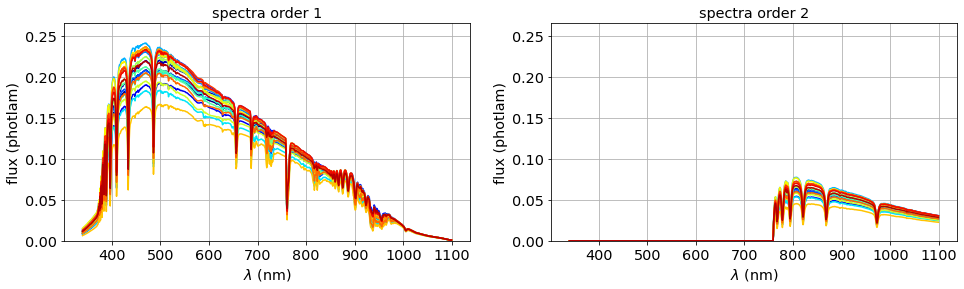

In [73]:
if FLAG_PLOT:
    
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(N):
        if spectra[idx,:].max()>themax:
            themax=spectra[idx,:].max()
        ax.plot(wl,spectra[idx,:],color=all_colors[idx])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (photlam)")
    ax.set_title(title_spec1)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(N):
        ax.plot(wl,spectra2[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (photlam)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec2)
    ax.grid()

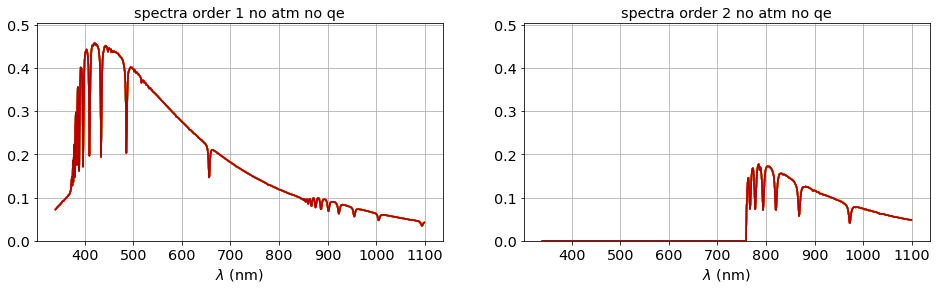

In [74]:
if FLAG_PLOT:
    
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(N):
        if spectra3[idx,:].max()>themax:
            themax=spectra3[idx,:].max()
        ax.plot(wl,spectra3[idx,:],color=all_colors[idx])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_title(title_spec3)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(N):
        ax.plot(wl,spectra4[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec4)
    ax.grid()

In [75]:
FLAG_CLOUD=True

if FLAG_CLOUD:
    X=-2.5*(np.log10(spectra*transm_cloud_arr)-np.log10(spectra3))
else:
    X=-2.5*(np.log10(spectra)-np.log10(spectra3))

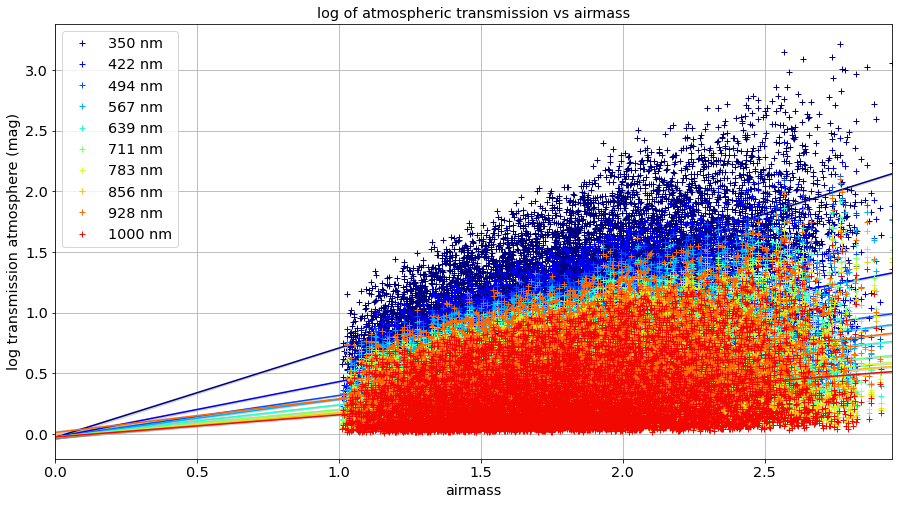

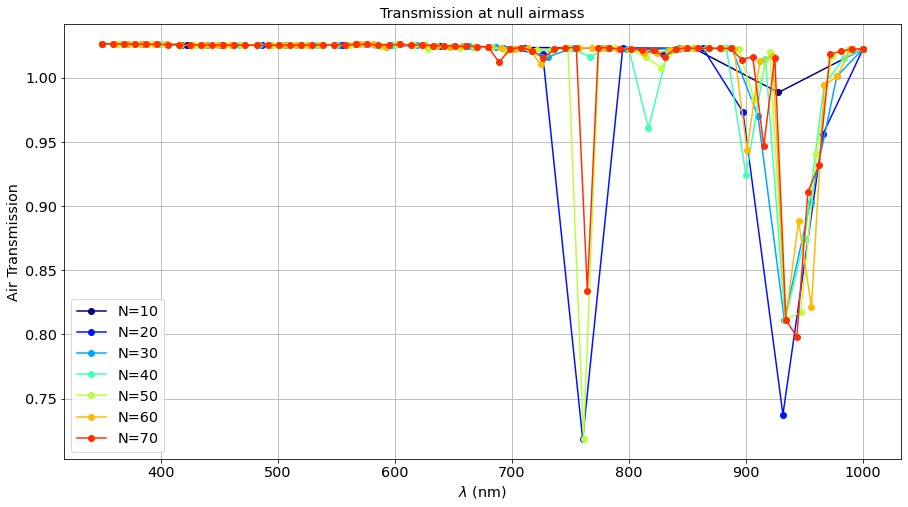

In [76]:
if FLAG_CLOUD:
    
    GetBouguerLinesAtm(NPOINTSVIEW,FLAG_PLOT=True)
    
    
if FLAG_PLOT and FLAG_CLOUD:
    fig=plt.figure(figsize=(15,8))
    ax=fig.add_subplot(111)
    
    
    NPOINTS=np.arange(10,80,10)
    NNPOINTS=len(NPOINTS)
    
    N=NNPOINTS
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(NNPOINTS):
        npoints=NPOINTS[idx]
        label=f"N={npoints}"
        w,m=GetBouguerLinesAtm(npoints,False)
        

        ax.plot(w,np.power(10,-m/2.5),'o-',color=all_colors[idx],label=label)

   
    ax.legend()
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("Air Transmission")
    ax.set_title("Transmission at null airmass")
    

### Check transmission or spectrum

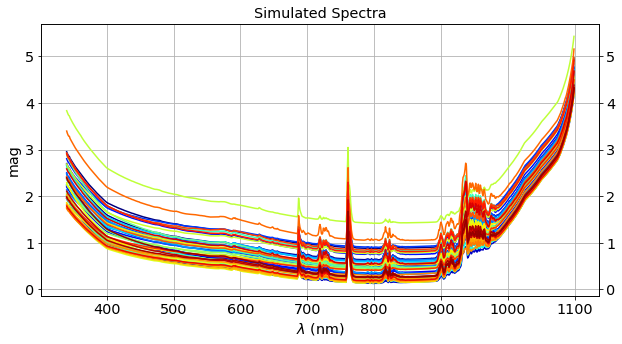

In [77]:
if FLAG_PLOT:
    N=50
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,X[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("mag")
    ax.set_title("Simulated Spectra")
    ax.grid()
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())

# Correlation coefficient X - Y

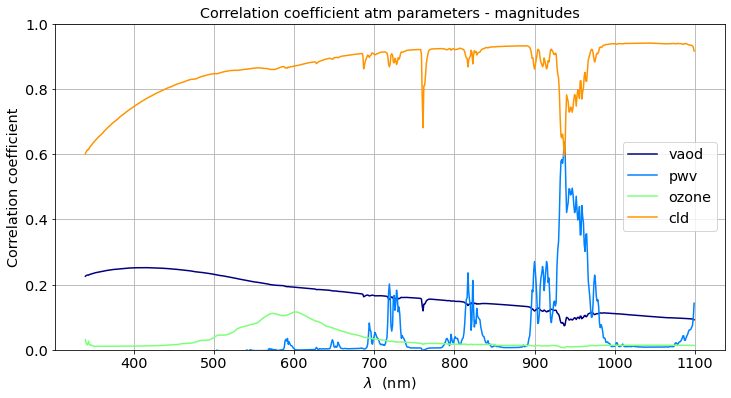

In [78]:
if FLAG_PLOT:
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111) 
    
    Ny=Y.shape[1]
    Nx=X.shape[1]
    
    N=Ny
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl,corr[iy,:],color=all_colors[iy],label=Ylabel[iy])
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation coefficient")
    ax.set_title("Correlation coefficient atm parameters - magnitudes")
    ax.grid()
    ax.set_ylim(0,1)

# Bouguer Lines

In [79]:
def GetBouguerLines(Npoints,FLAG_PLOT=True):
    """
    """
    wl_sel=np.linspace(350,1000,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel ]
    NIWSEL=len(iwl_sel)
    Mags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    the_y=X[:,iwl_sel]
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        the_y=X[:,iwl]

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        #z = np.polyfit(the_x, the_y, 1)
        #Mags[idx]=z[-1]
        #p = np.poly1d(z)
        #y_fit=p(x_fit)
        
        #if FLAG_PLOT:
        #    ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
        
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.5, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude (mag)")
        ax.set_title("magnitude vs airmass (SED and holo transmission subtracted)")
        plt.show()
    
    
    
    return wl_sel,Mags
    
  

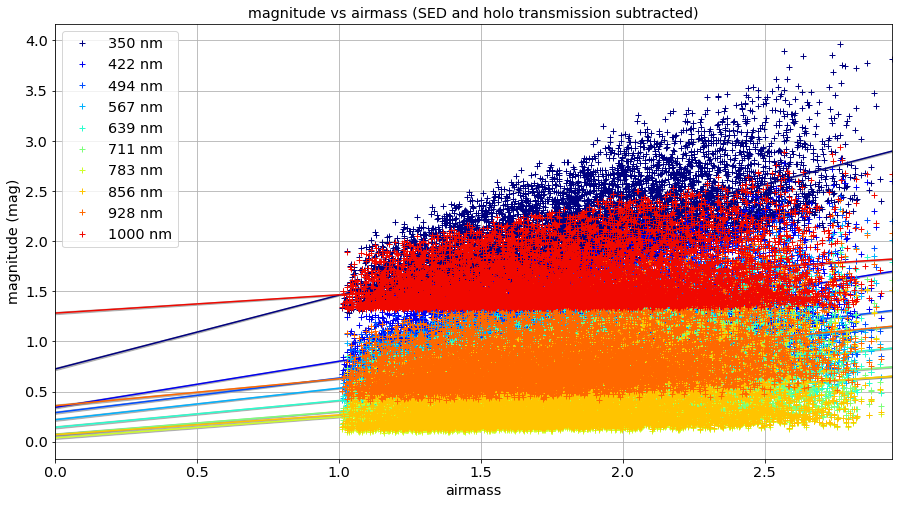

In [80]:
w10,m10=GetBouguerLines(NPOINTSVIEW,True)

In [81]:
# quantum efficiency
wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")

/Users/dagoret/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [82]:
from scipy import interpolate

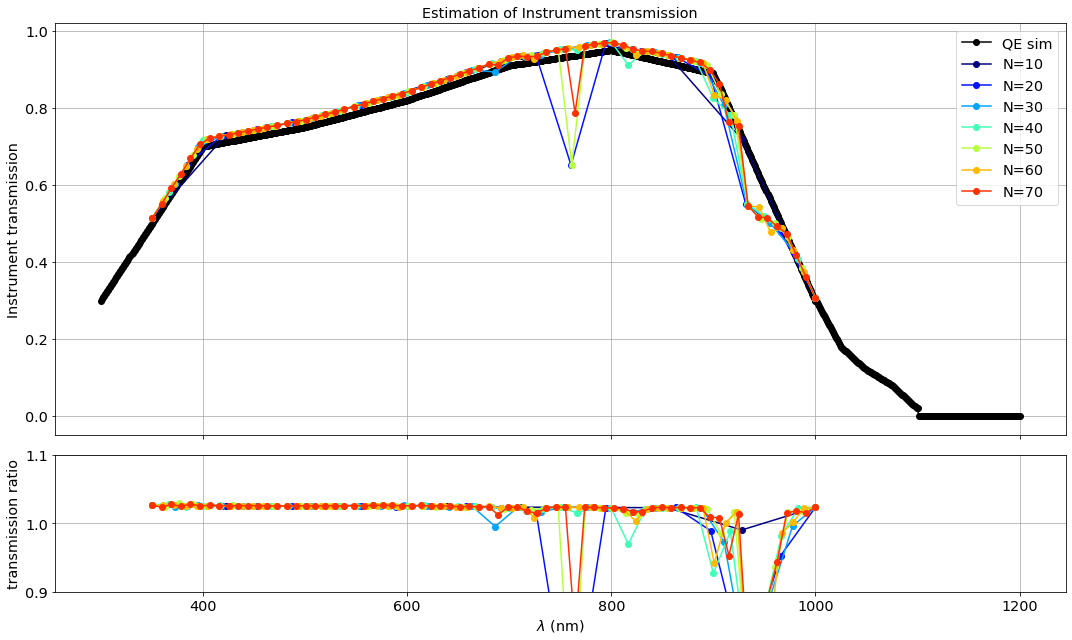

In [83]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,9))
    
    gs = fig.add_gridspec(2, 1,height_ratios=[3,1])
   
    
    #ax=fig.add_subplot(211)
    ax=fig.add_subplot(gs[0, :])
    
    ax.plot(wl_ccd,ccdqe,'o-k',label="QE sim")
    
    NPOINTS=np.arange(10,80,10)
    NNPOINTS=len(NPOINTS)
    
    N=NNPOINTS
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(NNPOINTS):
        npoints=NPOINTS[idx]
        label=f"N={npoints}"
        w,m=GetBouguerLines(npoints,False)
        
        ax.plot(w,np.power(10,-m/2.5),'o-',color=all_colors[idx],label=label)

   
    ax.legend()
    ax.grid()
    #ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("Instrument transmission")
    ax.set_title("Estimation of Instrument transmission")
    
    
   
   
    
    #ax2=fig.add_subplot(212)
    ax2=fig.add_subplot(gs[1, :])
    
    for idx in np.arange(NNPOINTS):
        npoints=NPOINTS[idx]
        label=f"N={npoints}"
        w,m=GetBouguerLines(npoints,False)
        
        func_ccd = interpolate.interp1d(wl_ccd, ccdqe)
        fccd=func_ccd(w)
        
        ax2.plot(w,np.power(10,-m/2.5)/fccd,'o-',color=all_colors[idx],label=label)

   
    #ax2.legend()
    ax2.grid()
    ax2.set_xlabel("$\lambda$ (nm)")
    ax2.set_ylabel("transmission ratio")
    #ax.set_title("Estimation of Instrument transmission")
    ax.get_shared_x_axes().join(ax, ax2)
    ax.set_xticklabels([])
    ax2.set_ylim(0.9,1.1)
    
    plt.tight_layout()
    
    
    